Device: cpu
[ESM] step=    1 train=1.050386  val(MSE true score)=1.023560
[ESM] step=  200 train=0.001294  val(MSE true score)=0.928792
[ESM] step=  400 train=0.003317  val(MSE true score)=0.794894
[ESM] step=  600 train=0.000792  val(MSE true score)=0.652860
[ESM] step=  800 train=0.000758  val(MSE true score)=0.519254
[ESM] step= 1000 train=0.001183  val(MSE true score)=0.402304
[ESM] step= 1200 train=0.002598  val(MSE true score)=0.304879
[ESM] step= 1400 train=0.000928  val(MSE true score)=0.226710
[ESM] step= 1600 train=0.000694  val(MSE true score)=0.165951
[ESM] step= 1800 train=0.000464  val(MSE true score)=0.119770
[ESM] step= 2000 train=0.000243  val(MSE true score)=0.085643
[ESM] step= 2200 train=0.000407  val(MSE true score)=0.060660
[ESM] step= 2400 train=0.000632  val(MSE true score)=0.042664
[ESM] step= 2600 train=0.000253  val(MSE true score)=0.029875
[ESM] step= 2800 train=0.000079  val(MSE true score)=0.020818
[ESM] step= 3000 train=0.000048  val(MSE true score)=0.014

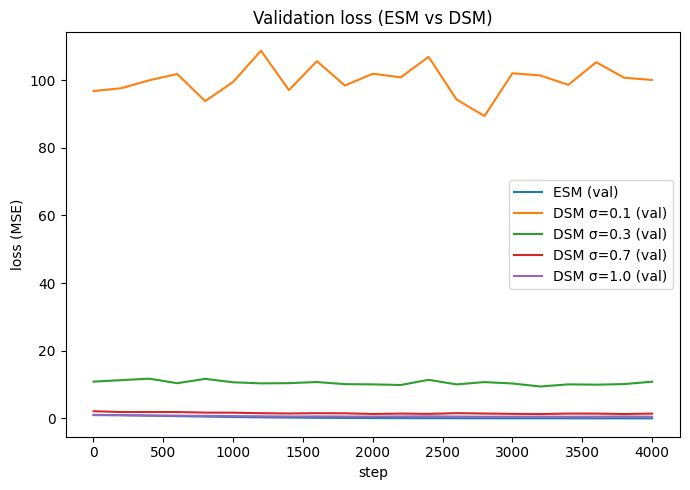

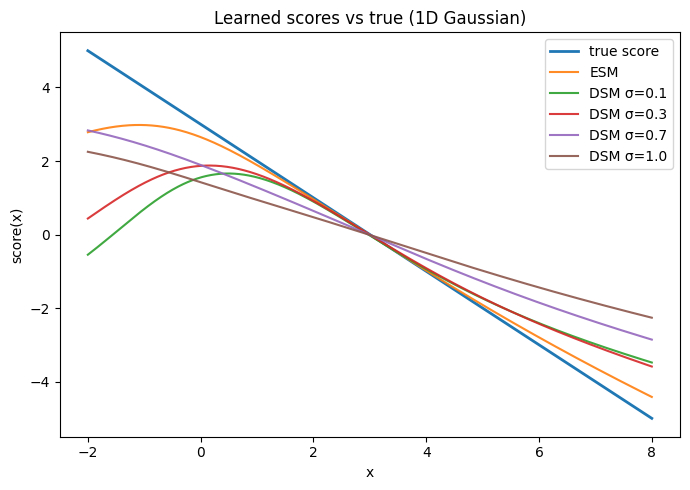


=== Summary (MSE vs true score on test) ===
ESM : 0.002499
DSM σ=0.1 : 0.029089
DSM σ=0.3 : 0.025509
DSM σ=0.7 : 0.124303
DSM σ=1.0 : 0.262735


In [2]:
# =========================
# Diffusion: ESM vs DSM (1D Gaussian)
# Ready-to-run PyTorch script
# =========================
import math, os, random, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# ----- Repro -----
SEED = 1234
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Data spec -----
MU = 3.0                 # data mean
SIG_DATA = 1.0           # sigma_data
# noise levels to try for DSM (will train one per sigma)
DSM_NOISES = [0.1, 0.3, 0.7, 1.0]

N_TRAIN = 50_000
N_VAL   = 10_000
N_TEST  = 10_000

# ----- Train config -----
BATCH = 256
LR    = 1e-3
STEPS = 4_000
PRINT_EVERY = 200
EMA_DECAY = 0.999

# =========================
# Utilities
# =========================
def sample_data(n, mu=MU, sig=SIG_DATA, device=DEVICE):
    x = torch.randn(n, 1, device=device) * sig + mu
    return x

def true_score(x, mu=MU, sig=SIG_DATA):
    # s*(x) = -(x-mu)/sig^2
    return -(x - mu) / (sig**2)

@torch.no_grad()
def make_grid(xmin=-2, xmax=8, num=400, device=DEVICE):
    g = torch.linspace(xmin, xmax, num, device=device).view(-1,1)
    return g

class EMA:
    def __init__(self, model, decay=EMA_DECAY):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.data.clone()

    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1.0-self.decay)

    def copy_to(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self.shadow[n])

# =========================
# Model
# =========================
class ScoreMLP(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 1),
        )
        # small init on final to stabilize early training
        nn.init.zeros_(self.net[-1].weight); nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        return self.net(x)

# =========================
# Training loops
# =========================
def train_esm(hidden=64):
    model = ScoreMLP(hidden).to(DEVICE)
    opt = Adam(model.parameters(), lr=LR)
    ema = EMA(model, EMA_DECAY)

    # pre-sample train/val
    x_tr = sample_data(N_TRAIN)
    x_va = sample_data(N_VAL)

    tr_hist, va_hist = [], []
    for step in range(1, STEPS+1):
        idx = torch.randint(0, x_tr.shape[0], (BATCH,), device=DEVICE)
        x = x_tr[idx]
        target = true_score(x)

        pred = model(x)
        loss = F.mse_loss(pred, target)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        ema.update(model)

        if step % PRINT_EVERY == 0 or step == 1:
            with torch.no_grad():
                ema.copy_to(model)
                # val MSE to true score
                pv = model(x_va)
                tv = true_score(x_va)
                vloss = F.mse_loss(pv, tv).item()
            tr_hist.append((step, loss.item()))
            va_hist.append((step, vloss))
            print(f"[ESM] step={step:5d} train={loss.item():.6f}  val(MSE true score)={vloss:.6f}")

    # freeze EMA weights at the end
    with torch.no_grad():
        ema.copy_to(model)
    return model, np.array(tr_hist), np.array(va_hist)

def train_dsm(sig_noise, hidden=64):
    model = ScoreMLP(hidden).to(DEVICE)
    opt = Adam(model.parameters(), lr=LR)
    ema = EMA(model, EMA_DECAY)

    # pre-sample clean data for pairs
    x0_tr = sample_data(N_TRAIN)
    x0_va = sample_data(N_VAL)

    tr_hist, va_hist = [], []
    for step in range(1, STEPS+1):
        idx = torch.randint(0, x0_tr.shape[0], (BATCH,), device=DEVICE)
        x0 = x0_tr[idx]
        eps = torch.randn_like(x0)
        x = x0 + sig_noise * eps
        target = -(x - x0) / (sig_noise**2)

        pred = model(x)
        loss = F.mse_loss(pred, target)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        ema.update(model)

        if step % PRINT_EVERY == 0 or step == 1:
            with torch.no_grad():
                ema.copy_to(model)
                # Use validation pairs
                idv = torch.randint(0, x0_va.shape[0], (BATCH*4,), device=DEVICE)
                x0v = x0_va[idv]
                epsv = torch.randn_like(x0v)
                xv = x0v + sig_noise * epsv
                tv = -(xv - x0v) / (sig_noise**2)
                vloss = F.mse_loss(model(xv), tv).item()
            tr_hist.append((step, loss.item()))
            va_hist.append((step, vloss))
            print(f"[DSM σ={sig_noise}] step={step:5d} train={loss.item():.6f}  val(MSE cond score)={vloss:.6f}")

    with torch.no_grad():
        ema.copy_to(model)
    return model, np.array(tr_hist), np.array(va_hist)

# =========================
# Evaluation helpers
# =========================
@torch.no_grad()
def eval_true_score_mse(model):
    # evaluate MSE on an i.i.d. sample from p_data against true score
    x_te = sample_data(N_TEST)
    mse = F.mse_loss(model(x_te), true_score(x_te)).item()
    return mse

@torch.no_grad()
def plot_scores(models_dict, title_suffix=""):
    grid = make_grid(-2, 8, 600)
    s_true = true_score(grid).cpu().numpy()

    plt.figure(figsize=(7,5))
    plt.plot(grid.cpu().numpy(), s_true, label="true score", linewidth=2)

    for name, mdl in models_dict.items():
        s_hat = mdl(grid).cpu().numpy()
        plt.plot(grid.cpu().numpy(), s_hat, label=name, alpha=0.9)
    plt.xlabel("x"); plt.ylabel("score(x)")
    plt.title(f"Learned scores vs true{title_suffix}")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_curves(curves, title):
    plt.figure(figsize=(7,5))
    for label, arr in curves:
        steps, vals = arr[:,0], arr[:,1]
        plt.plot(steps, vals, label=label)
    plt.xlabel("step"); plt.ylabel("loss (MSE)")
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

# =========================
# Run experiments
# =========================
if __name__ == "__main__":
    print("Device:", DEVICE)

    # Train ESM
    esm_model, esm_tr, esm_va = train_esm(hidden=64)
    esm_mse = eval_true_score_mse(esm_model)
    print(f"\n[ESM] test MSE vs true score = {esm_mse:.6f}")

    # Train DSM for each sigma_noise
    dsm_models = {}
    dsm_curves = []
    for sig in DSM_NOISES:
        mdl, tr, va = train_dsm(sig_noise=sig, hidden=64)
        dsm_models[f"DSM σ={sig}"] = mdl
        # Evaluate each DSM also against true score (note: with σ>0 they learn smoothed score; σ→0 會更接近)
        mse = eval_true_score_mse(mdl)
        print(f"[DSM σ={sig}] test MSE vs true score = {mse:.6f}")
        dsm_curves.append((f"DSM σ={sig} (val)", va))

    # -------- Plots --------
    # 1) Training/validation curves
    plot_curves([("ESM (val)", esm_va)] + dsm_curves, title="Validation loss (ESM vs DSM)")

    # 2) Learned score on a grid
    plot_scores({"ESM": esm_model, **dsm_models}, title_suffix=" (1D Gaussian)")

    # 3) Optional: print a compact summary
    print("\n=== Summary (MSE vs true score on test) ===")
    print(f"ESM : {esm_mse:.6f}")
    for k, m in dsm_models.items():
        print(f"{k:<10}: {eval_true_score_mse(m):.6f}")
